## Periodic pattern mining on canadian TV logs
<img src="skmine_series.png" alt="logo" style="width: 60%;"/>

In [1]:
import skmine

print("This tutorial was tested with the following version of skmine :", skmine.__version__)

print("""
Be sure to execute this notebook in the dir `docs/tutorials/periodic`, 
to be able to load the data files `.csv`. 
If not, please do so and adapt the bash commands below 
""")

%pwd
# %cd docs/tutorials/periodic

This tutorial was tested with the following version of skmine : 0.0.11

Be sure to execute this notebook in the dir `docs/tutorials/periodic`, 
to be able to load the data files `.csv`. 
If not, please do so and adapt the bash commands below 



'/home/cregan/Documents/CODE/Projets/3_FWIN/Scikit_mind/scikit-mine/docs/tutorials/periodic'

### The problem, informally
Let's take a simple example. 

Imagine you set an alarm to wake up every day around 7:30AM, and go to work. Sometimes you wake up a bit earlier (your body anticipates on the alarm), and sometimes a bit later, for example if you press the "snooze" button and refuse to face the fact that you have to wake up.

In python we can load those "wake up" events as logs, and store them in a [pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html), like

In [2]:
import datetime as dt
import pandas as pd
one_day = 60 * 24  # a day in minutes
minutes = [0, one_day - 1, one_day * 2 - 1, one_day * 3, one_day * 4 + 2, one_day * 7]

S = pd.Series("wake up", index=minutes)
start = dt.datetime.strptime("16/04/2020 07:30", "%d/%m/%Y %H:%M")
S.index = S.index.map(lambda e: start + dt.timedelta(minutes=e))
S.index = S.index.round("min")  # minutes as the lowest unit of difference
S

2020-04-16 07:30:00    wake up
2020-04-17 07:29:00    wake up
2020-04-18 07:29:00    wake up
2020-04-19 07:30:00    wake up
2020-04-20 07:32:00    wake up
2020-04-23 07:30:00    wake up
dtype: object

In [3]:
S.index.to_numpy()

array(['2020-04-16T07:30:00.000000000', '2020-04-17T07:29:00.000000000',
       '2020-04-18T07:29:00.000000000', '2020-04-19T07:30:00.000000000',
       '2020-04-20T07:32:00.000000000', '2020-04-23T07:30:00.000000000'],
      dtype='datetime64[ns]')

We can see the wake-up time is not exactly the same every day, but overall a consistent regular pattern seems to emerge.

Now imagine that in addition to wake up times, we also have records of other daily activities (meals, work, household chores, etc.), and that rather than a handful of days, those records span several years and make up several thousands of events

**How would you be able to detect regularities in the data ?**

### Introduction to periodic pattern mining
Periodic pattern mining aims at exploiting regularities not only about `what happens` by finding coordinated event occurrences, but also about `when it happens` and `how it happens`, by **finding consistent inter-occurrence timeintervals**.

Next, we introduce the concept of cycles

#### The cycle : a building block for periodic pattern mining
Here is an explicit example of a cycle

<img src="cycle_color.png" alt="cycle" style="width: 60%;"/>

This definition, while being relatively simple, is general enough to allow us to find regularities in different types of logs

#### Handling noise in our timestamps

Needless to say, it would be too easy if events in our data were equally spaced. As data often comes noisy, we have to be fault tolerant, and allow small errors to sneak into our cycles. 

That's the role of `shift corrections`, which capture the small deviations from perfectly regular periodic repetitions, and allow to reconstruct the (noisy) original sequence of events, using the following relation
<img src="shifts.png" alt="shifts" style="width: 60%;"/>

#### A tiny example with scikit-mine
`scikit-mine` offers a `PeriodicPatternMiner`, out of the box.
You can use it to **detect regularities, in the form of cycles**, in the input data. 

These regularities are submitted to an MDL criterion, so that we do not mistakenly include redundant occurences, nor forget to consider other intervals that would sumarize our data in a better way.

MDL offers a framework to find `the best set of cycles`, i.e the set that gives the most succint representation of the data. And `as humans, we often like to deal with non-redundant, well organized data`.

In [4]:
from skmine.periodic import PeriodicPatternMiner
import pandas as pd
S_doc = pd.Series("ring_a_bell", [10, 20, 32, 40, 60, 79, 100, 240])
pcm = PeriodicPatternMiner().fit(S_doc)
pcm.discover()

Autoscale before first S.index 

10
20
32
40
Autoscale after first S.index
  Index([10, 20, 32, 40], dtype='int64')
Autoscale DeltaT 230
Autoscale remove nb zeros  0


,t0,pattern,repetition_major,period_major,sum_E
0,20,(ring_a_bell)[r=5 p=20],5,20,2


In [5]:
from skmine.periodic import PeriodicPatternMiner
import pandas as pd

In [6]:
pcm = PeriodicPatternMiner().fit(S)

Autoscale before first S.index 

2020-04-16 07:30:00
2020-04-17 07:29:00
2020-04-18 07:29:00
2020-04-19 07:30:00
Autoscale after first S.index
  Index([158702220, 158710854, 158719494, 158728140], dtype='int64')
Autoscale DeltaT 60480
Autoscale remove nb zeros  10


In [7]:
pcm.discover()

,t0,pattern,repetition_major,period_major,sum_E
0,2020-04-16 07:30:00,"(wake up)[r=5 p=1 day, 0:00:30]",5,1 days 00:00:30,0 days 00:04:00


You can see one cycle has been extracted for our event `wake up`. The cycle covers the entire business week, but not the last monday separated by the weekend

It has a length of 5 and a period close to 1 day, as expected.

Also, note that we "lost" some information here. Our period of 1 day offers the best summary for this data.
Accessing the little "shifts" as encountered in original data is also possible, with an extra argument in our `.discover` call

The last column named `dE` contains a list of shifts to apply to our cycle in case we want to reconstruct the original data. Trailing zeros have been removed for efficiency, and their values are `relative to the period`, but we can see there is:
 * a -90 second shift between the 1st and 2nd entry (1day30s - 90s later = waking up at 7:29 on tuesday)
 * a 30 second shift between the 2nd and 3rd entry (1day30s - 30s later = still waking up at 7:29 on wednesday)
 * an 30 second shift between the 3rd and 4th entry (back to 7:30 on thursday)
 * an 90 second shift between the 4th and 5th entry (1day 30s + 90s later = waking up at 7:32 on friday)

Also note that we can get the "uncovered" events, called `redisuals`

In [8]:
pcm.get_residuals()

,time,event
0,2020-04-23 07:30:00,wake up


This way `pcm` does not store all the data, but has all information needed to reconstruct it entirely !!

In [9]:
pcm.reconstruct()

,time,event
0,2020-04-16 07:30:00,wake up
1,2020-04-17 07:29:00,wake up
2,2020-04-18 07:29:00,wake up
3,2020-04-19 07:30:00,wake up
4,2020-04-20 07:32:00,wake up


-----
### An example with Canadian TV programs
#### Fetching logs from canadian TV

In this section we are going to load some event logs of TV programs (the `WHAT`), indexed by their broadcast timestamps (the `WHEN`).

`PeriodicPatternMiner` is here to help us discovering regularities (the `HOW`)

In [10]:
from skmine.datasets import fetch_canadian_tv
from skmine.periodic import PeriodicPatternMiner

#### Searching for cycles in TV programs

Remember about the definition of cycles ?
Let's apply it to our TV programs

In our case

* $\alpha$ is the name of a TV program

* $r$ is the number of broadcasts (repetitions) for this TV program (inside this cycle)

* $p$ is the optimal time delta between broadcasts in this cycle. If a program is meant to be live everyday at 14:00PM, then $p$ is likely to be `1 day`

* $\tau$ is the first broadcast time in this cycle

* $dE$ are the shift corrections between the $p$ and the actual broadcast time of an event. If a TV program was scheduled at 8:30:00AM and it went on air at 8:30:23AM the same day, then we keep track of a `23 seconds shift`. This way we can summarize our data (via cycles), and reconstruct it (via shift corrections). 


Finally we are going to dig a little deeper into these cycles, to answer quite complex questions about our logs. We will see that cycles contains usefull information about our input data

In [11]:
ctv_logs = fetch_canadian_tv()
ctv_logs.head()

timestamp
2020-08-01 06:00:00            The Moblees
2020-08-01 06:11:00    Big Block Sing Song
2020-08-01 06:13:00    Big Block Sing Song
2020-08-01 06:15:00               CBC Kids
2020-08-01 06:15:00               CBC Kids
Name: canadian_tv, dtype: string

Compute only simple cycles on ctv_logs with the karg *complex=False* : 

In [12]:
pcm = PeriodicPatternMiner().fit(ctv_logs, complex=False)
pcm.discover()

/home/cregan/miniconda3/envs/test_skmine/lib/python3.8/site-packages/scikit_mine-0.0.11-py3.8.egg/skmine/periodic/cycles.py:150: UserWarning: found 234 duplicates in the input sequence, they have been removed.
  warnings.warn(f"found {diff} duplicates in the input sequence, they have been removed.")


Autoscale before first S.index 

2020-08-01 01:12:00
2020-08-01 04:00:00
2020-08-01 04:30:00
2020-08-01 05:00:00
Autoscale after first S.index
  Index([159624432, 159625440, 159625620, 159625800], dtype='int64', name='timestamp')
Autoscale DeltaT 267138
Autoscale remove nb zeros  10


,t0,pattern,repetition_major,period_major,sum_E
57,2020-08-01 04:00:00,"(Rick Mercer Report)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
58,2020-08-01 04:30:00,"(Rick Mercer Report)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
0,2020-08-01 05:00:00,"(Grand Designs)[r=31 p=1 day, 0:00:00]",31,1 days 00:00:00,0 days 00:00:00
65,2020-08-01 06:00:00,"(The Moblees)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
25,2020-08-01 06:11:00,"(Big Block Sing Song)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
...,...,...,...,...,...
277,2020-08-26 04:00:00,(CBC News: The National)[r=3 p=21:00:00],3,0 days 21:00:00,0 days 00:00:00
231,2020-08-26 10:59:00,"(CBC Kids)[r=4 p=1 day, 0:00:00]",4,1 days 00:00:00,0 days 00:02:00
276,2020-08-26 14:00:00,"(Jamie's Super Foods)[r=3 p=1 day, 0:00:00]",3,1 days 00:00:00,0 days 00:00:00
190,2020-08-27 02:00:00,(Mr. D)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00


Compute simple and complex (with horizontal and vertical combinations) cycles on ctv_logs : 

In [13]:
pcm = PeriodicPatternMiner().fit(ctv_logs)

/home/cregan/miniconda3/envs/test_skmine/lib/python3.8/site-packages/scikit_mine-0.0.11-py3.8.egg/skmine/periodic/cycles.py:150: UserWarning: found 234 duplicates in the input sequence, they have been removed.
  warnings.warn(f"found {diff} duplicates in the input sequence, they have been removed.")


Autoscale before first S.index 

2020-08-01 01:12:00
2020-08-01 04:00:00
2020-08-01 04:30:00
2020-08-01 05:00:00
Autoscale after first S.index
  Index([159624432, 159625440, 159625620, 159625800], dtype='int64', name='timestamp')
Autoscale DeltaT 267138
Autoscale remove nb zeros  10


In [14]:
cycles = pcm.discover()
cycles

,t0,pattern,repetition_major,period_major,sum_E
51,2020-08-01 04:00:00,"(Rick Mercer Report)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
45,2020-08-01 04:30:00,(Rick Mercer Report [d=1:47:00] The Adventures...,5,7 days 00:00:00,0 days 00:01:00
0,2020-08-01 05:00:00,"(Grand Designs)[r=31 p=1 day, 0:00:00]",31,1 days 00:00:00,0 days 00:00:00
9,2020-08-01 06:00:00,(The Moblees [d=0:11:00] Big Block Sing Song [...,5,7 days 00:00:00,0 days 00:01:00
96,2020-08-01 06:30:00,"(Daniel Tiger's Neighbourhood)[r=5 p=6 days, 2...",5,6 days 23:59:30,0 days 00:03:00
...,...,...,...,...,...
93,2020-08-25 02:00:00,(This Hour Has 22 Minutes)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00
24,2020-08-26 00:30:00,(Kim's Convenience)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
105,2020-08-26 14:00:00,(Jamie's Super Foods [d=5:30:00] Just For Laug...,3,1 days 00:00:00,0 days 00:00:00
91,2020-08-27 02:00:00,(Mr. D)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00


`Note` : no need to worry for the warning, it's here to notify duplicate event/timestamp pairs have been found

#### Viewing the patterns

Sometimes the patterns are complicated to understand textually. The `draw_pattern` function allows you to visualise them. Simply indicate in pattern the id of the pattern you wish to view from the results of the previous discover.

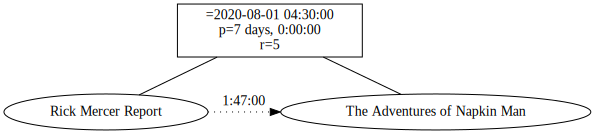

In [15]:
pcm.draw_pattern(45) 
# if you want to save the tree, you can add a `directory` parameter to indicate the location of the results (pdf + generated DOT file)

#### Patterns import - export 

In [16]:
#Store in a json file the patterns ("patterns.json" by default) 
pcm.export_patterns(file = "patterns.json")

# reinitialize the PeriodicPatternMiner : 
pcm = PeriodicPatternMiner()

# import the json file ("patterns.json" by default)
pcm.import_patterns(file = "patterns.json")

# recompute the pattern : 
cycles = pcm.discover()
cycles

,t0,pattern,repetition_major,period_major,sum_E
0,2020-08-01 04:00:00,"(Rick Mercer Report)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
1,2020-08-01 04:30:00,(Rick Mercer Report [d=1:47:00] The Adventures...,5,7 days 00:00:00,0 days 00:01:00
2,2020-08-01 05:00:00,"(Grand Designs)[r=31 p=1 day, 0:00:00]",31,1 days 00:00:00,0 days 00:00:00
3,2020-08-01 06:00:00,(The Moblees [d=0:11:00] Big Block Sing Song [...,5,7 days 00:00:00,0 days 00:01:00
4,2020-08-01 06:30:00,"(Daniel Tiger's Neighbourhood)[r=5 p=6 days, 2...",5,6 days 23:59:30,0 days 00:03:00
...,...,...,...,...,...
135,2020-08-25 02:00:00,(This Hour Has 22 Minutes)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00
136,2020-08-26 00:30:00,(Kim's Convenience)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
137,2020-08-26 14:00:00,(Jamie's Super Foods [d=5:30:00] Just For Laug...,3,1 days 00:00:00,0 days 00:00:00
138,2020-08-27 02:00:00,(Mr. D)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00


Now that we have our cycles in a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), we can play with the pandas API and answer questions about our logs

#### Did I find cycles for the TV show "Arthurt Shorts"

In [17]:
cycles

,t0,pattern,repetition_major,period_major,sum_E
0,2020-08-01 04:00:00,"(Rick Mercer Report)[r=5 p=7 days, 0:00:00]",5,7 days 00:00:00,0 days 00:00:00
1,2020-08-01 04:30:00,(Rick Mercer Report [d=1:47:00] The Adventures...,5,7 days 00:00:00,0 days 00:01:00
2,2020-08-01 05:00:00,"(Grand Designs)[r=31 p=1 day, 0:00:00]",31,1 days 00:00:00,0 days 00:00:00
3,2020-08-01 06:00:00,(The Moblees [d=0:11:00] Big Block Sing Song [...,5,7 days 00:00:00,0 days 00:01:00
4,2020-08-01 06:30:00,"(Daniel Tiger's Neighbourhood)[r=5 p=6 days, 2...",5,6 days 23:59:30,0 days 00:03:00
...,...,...,...,...,...
135,2020-08-25 02:00:00,(This Hour Has 22 Minutes)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00
136,2020-08-26 00:30:00,(Kim's Convenience)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
137,2020-08-26 14:00:00,(Jamie's Super Foods [d=5:30:00] Just For Laug...,3,1 days 00:00:00,0 days 00:00:00
138,2020-08-27 02:00:00,(Mr. D)[r=4 p=0:30:00],4,0 days 00:30:00,0 days 00:00:00


In [18]:
cycles[cycles["pattern"].apply(lambda x: "Arthur Shorts" in x)]

,t0,pattern,repetition_major,period_major,sum_E
18,2020-08-01 08:59:00,(CBC Kids [d=0:22:00] CBC Kids [d=1:27:00] Add...,5,7 days 00:00:00,0 days 00:00:00
59,2020-08-03 09:35:00,"((Arthur Shorts)[r=5 p=1 day, 0:00:00] [d=0:13...",3,6 days 23:59:00,0 days 00:08:00
131,2020-08-24 07:43:00,((CBC Kids)[r=4 p=0:25:00] [d=2:05:00] Arthur ...,4,1 days 00:00:00,0 days 00:04:00
132,2020-08-24 09:35:00,(CBC Kids [d=0:00:00] Arthur Shorts)[r=4 p=1 d...,4,1 days 00:00:00,0 days 00:02:00


#### What are the top 10 longest cycles ?

In [19]:
cycles.nlargest(10, ["repetition_major"])

,t0,pattern,repetition_major,period_major,sum_E
2,2020-08-01 05:00:00,"(Grand Designs)[r=31 p=1 day, 0:00:00]",31,1 days 00:00:00,0 days 00:00:00
13,2020-08-01 07:43:00,"(CBC Kids)[r=26 p=1 day, 0:00:00]",26,1 days 00:00:00,0 days 00:10:00
122,2020-08-17 07:22:00,"(CBC Kids)[r=12 p=1 day, 0:00:00]",12,1 days 00:00:00,0 days 00:07:00
139,2020-08-28 00:00:00,(Schitt's Creek)[r=8 p=0:30:00],8,0 days 00:30:00,0 days 00:00:00
75,2020-08-05 00:30:00,(Kim's Convenience)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
82,2020-08-06 00:30:00,(Mr. D)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
88,2020-08-07 00:30:00,(Schitt's Creek)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
136,2020-08-26 00:30:00,(Kim's Convenience)[r=7 p=0:30:00],7,0 days 00:30:00,0 days 00:00:00
94,2020-08-07 09:12:00,"(CBC Kids)[r=6 p=3 days, 23:47:00]",6,3 days 23:47:00,0 days 00:04:00
128,2020-08-23 07:27:00,"(CBC Kids)[r=6 p=1 day, 0:00:00]",6,1 days 00:00:00,0 days 00:00:00


In [20]:
pcm.reconstruct([1])

,time,event
0,2020-08-01 04:30:00,Rick Mercer Report
1,2020-08-01 06:17:00,The Adventures of Napkin Man
2,2020-08-08 04:30:00,Rick Mercer Report
3,2020-08-08 06:17:00,The Adventures of Napkin Man
4,2020-08-15 04:30:00,Rick Mercer Report
5,2020-08-15 06:17:00,The Adventures of Napkin Man
6,2020-08-22 04:30:00,Rick Mercer Report
7,2020-08-22 06:16:00,The Adventures of Napkin Man
8,2020-08-29 04:30:00,Rick Mercer Report
9,2020-08-29 06:17:00,The Adventures of Napkin Man


In [21]:
pcm.get_residuals()

,time,event
51,2020-08-01 01:12:00,OLYMPIC GAMES REPLAY
129,2020-08-01 06:17:00,CBC Kids
289,2020-08-01 06:30:00,CBC Kids
412,2020-08-01 08:08:00,CBC Kids
256,2020-08-01 08:35:00,CBC Kids
...,...,...
26,2020-08-31 16:00:00,Escape to the Country
249,2020-08-31 17:00:00,Murdoch Mysteries
312,2020-08-31 17:59:00,News
79,2020-08-31 19:00:00,Hockey Night in Canada


#### what are the 10 most unpunctual TV programs ?
For this we are going to :
 1. extract the shift corrections along with other informations about our cycles
 2. compute the sum of the absolute values for the shift corrections, for every cycles
 3. get the 10 biggest sums

In [22]:
# full_cycles = pcm.discover()
# full_cycles.head()

In [23]:
# def absolute_sum(*args):
#     return sum(map(abs, *args))

# # level 0 is the name of the TV program
# shift_sums = full_cycles["dE"].map(absolute_sum).groupby(level=[0]).sum()
# shift_sums.nlargest(10)

<!-- #### what are the 10 most unpunctual TV programs ?
For this we are going to :
 1. extract the shift corrections along with other informations about our cycles
 2. compute the sum of the absolute values for the shift corrections, for every cycles
 3. get the 10 biggest sums -->

In [24]:
# def absolute_sum(*args):
#     return sum(map(abs, *args))

# # level 0 is the name of the TV program
# shift_sums = full_cycles["dE"].map(absolute_sum).groupby(level=[0]).sum()
# shift_sums.nlargest(10)

#### What TV programs have been broadcasted every day for at least 5 days straight?
Let's make use of the [pandas.DataFrame.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) method to express our question in an SQL-like syntax

In [25]:
# cycles.query('length_major >= 5 and period_major >= 3600', engine='python')
# # cycles.query('length >= 5 and period == "1 days"', engine='python')

#### What TV programs are broadcast only on business days ?
From the previous query we see we have a lot of 5-length cycles, with periods of 1 day.
An intuition is that these cycles take place on business days. Let's confirm this by considering cycles with
 1. start timestamps on mondays
 2. periods of roughly 1 day  

In [26]:
# monday_starts = cycles[cycles.start.dt.weekday == 0]  # start on monday
# monday_starts.query('length == 5 and period == "1 days"', engine='python')

------
### Load your own custom datasets

If you want to **use your own datasets from file**, you can use the `fetch_file` function.  
There are **3 ways to write** :

#### 1. **Each line consists of a datetime followed by its associated event.** By default, **the separator is a `,`**. This is customisable.  
Example :

In [27]:
with open("dataset_datetime.csv", "r") as f:
    data = f.read().splitlines()
    
data

['2020-04-16 07:30:00,wake up',
 '2020-04-17 07:29:00,wake up',
 '2020-04-17 07:29:00,wake up',
 '2020-04-18 07:29:00,wake up',
 '2020-04-19 07:30:00,wake up',
 '2020-04-20 07:32:00,wake up',
 '2020-04-23 07:30:00,wake up']

In [28]:
from skmine.datasets.periodic import fetch_file

data = fetch_file("dataset_datetime.csv", separator=",")  # by default separator is already comma
pcm = PeriodicPatternMiner().fit(data)
pcm.discover()

Autoscale before first S.index 

2020-04-16 07:30:00
2020-04-17 07:29:00
2020-04-18 07:29:00
2020-04-19 07:30:00
Autoscale after first S.index
  Index([158702220, 158710854, 158719494, 158728140], dtype='int64', name='timestamp')
Autoscale DeltaT 60480
Autoscale remove nb zeros  10


/home/cregan/miniconda3/envs/test_skmine/lib/python3.8/site-packages/scikit_mine-0.0.11-py3.8.egg/skmine/periodic/cycles.py:150: UserWarning: found 1 duplicates in the input sequence, they have been removed.
  warnings.warn(f"found {diff} duplicates in the input sequence, they have been removed.")


,t0,pattern,repetition_major,period_major,sum_E
0,2020-04-16 07:30:00,"(wake up)[r=5 p=1 day, 0:00:30]",5,1 days 00:00:30,0 days 00:04:00


Note that several formats for datetimes can be infered from example. But you can force to parse string according to a specific format with the extra option : `format="%d/%m/%Y %H:%M:%S"` . see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior for all possibilities
- `2020-04-23 07:30:00` -> YYYY-MM-DD hh:mm:ss
- `1997-07-23T19:20+01:00` -> YYYY-MM-DDThh:mmTZD (TZD = time zone designator)
- `1997-07-23T19:20:30.45+01:00` -> YYYY-MM-DDThh:mm:ss.sTZD
- `02/23/2018` -> MM/DD/YYYY
- `02/23/18` -> MM/DD/YY
- ...

**2 points of caution** are to be noted:
- **Beware of this type of format "Feb 23, 2018" (Mth d, YYYY)** because comma is the default separator. If you want to use this format, you must use **double quotes around the date**.
- **The MM/DD (Month/day) format is infered by default (when day is less than 12)**, for DD/MM; use format option as in example below:  
 

In [29]:
fetch_file("dataset_datetime_DD_MM.csv",  separator=',' ,format="%d/%m/%Y %H:%M:%S")

timestamp
2018-02-10 07:30:00    wake up
2018-02-23 07:30:00     coffee
2018-03-10 07:30:00    wake up
Name: dataset_datetime_DD_MM.csv, dtype: string

 
#### 2. **Datetimes can also be replaced by integers**.  
    Example:

In [30]:
with open("dataset_integer.csv", "r") as f:
    data = f.read().splitlines()
    
data

['1,wake up',
 '3,wake up',
 '10,wake up',
 '30,wake up',
 '40,wake up',
 '70,wake up',
 '100,wake up']

#### 3. **Use only the name of the events**. In this case, **the indexes correspond to the line numbers (starting from 0)**.  
Example:

In [31]:
with open("dataset_no_index.csv", "r") as f:
    data = f.read().splitlines()
    
data

['wake up', 'wake up', 'wake up', 'wake up', 'wake up', 'wake up', 'wake up']

In [32]:
data = fetch_file("dataset_no_index.csv")
data

timestamp
0    wake up
1    wake up
2    wake up
3    wake up
4    wake up
5    wake up
6    wake up
Name: dataset_no_index.csv, dtype: string

References
----------

1. Galbrun, E & Cellier, P & Tatti, N & Termier, A & Crémilleux, B
   "Mining Periodic Pattern with a MDL Criterion"

2. Galbrun, E
   "The Minimum Description Length Principle for Pattern Mining : A survey"  

3. Termier, A
   ["Periodic pattern mining"](http://people.irisa.fr/Alexandre.Termier/dmv/DMV_Periodic_patterns.pdf) 